In [1]:
# adaped from: https://forum.image.sc/t/call4help-3d-dense-nuclei-segmentation-challenge/23462/12

In [2]:
import tifffile as tif
import os

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import filters
from sklearn.cluster import DBSCAN
from skimage.filters import threshold_otsu
from collections import namedtuple
from scipy.ndimage.morphology import binary_fill_holes

Cluster = namedtuple('Cluster', 'contour center area perimeter rectangle_min rectangle_max hull_length')


def get_sobel_images(img_gray):
    img_dx = filters.sobel(img_gray, 0)  # horizontal derivative
    img_dy = filters.sobel(img_gray, 1)  # vertical derivative
    img_sobel = np.hypot(img_dx, img_dy)  # magnitude

    return img_dx, img_dy, img_sobel


def get_grid_points(img_gray, mask):
    # Make input matrix
    img_size = img_gray.shape
    X, Y = np.meshgrid(np.arange(img_size[1]), np.arange(img_size[0]))
    grid_points = np.vstack([X[mask], Y[mask]]).T

    return grid_points


def get_cluster_list(grid_points, in_labels, img, options):

    img_size = img.shape

    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(set(in_labels)) - (1 if -1 in in_labels else 0)
   
  

    print('Estimated number of clusters: %d' % n_clusters)
   

    cluster_list = []
    single_cluster_mask = np.zeros(img_size, dtype=np.uint8)
    cluster_image = np.zeros(img_size, dtype=np.int32)

    out_label = 1
    # plt.figure(10)

    for k in range(n_clusters):
        cl_points_ind = in_labels == k

        points = grid_points[cl_points_ind]

        single_cluster_mask[points[:, 1], points[:, 0]] = 1
        contour, _ = cv2.findContours(single_cluster_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        for cont in contour:
            # Calculate cluster properties
            area = cv2.contourArea(cont)
            # Ignore one pixel thin contours
            if area > 0:
                center = np.mean(np.squeeze(cont), axis=0)
                min_rect = cv2.minAreaRect(cont)

                rectangle_min = min(min_rect[1])
                rectangle_max = max(min_rect[1])

                perimeter = cv2.arcLength(cont, True)

                # convex hull
                hull = cv2.convexHull(cont)
                hull_length = cv2.arcLength(hull, True)

                cv2.drawContours(cluster_image, [cont], 0, out_label, thickness=cv2.FILLED)
               
                cluster_list.append(
                    Cluster(np.squeeze(cont), center, area, perimeter, rectangle_min, rectangle_max, hull_length))

                out_label += 1

        # Clear cluster image (we want only one cluster at a time)
        single_cluster_mask[:] = 0

    return cluster_list, cluster_image


def show_clusters_DBSCAN(img_gray, cluster_list):

    colors = np.random.permutation(plt.cm.Spectral(np.linspace(0, 1, len(cluster_list))))

    for cluster, col in zip(cluster_list, colors):
        plt.plot(cluster.contour[:, 0], cluster.contour[:, 1], '.', color=col, alpha=0.5)
     
    plt.title('Estimated number of clusters: %d' % len(cluster_list))
    return cluster






def segment_dbscan(img_gray, options):

    blur_kernel = (int(options["BlurKernelSize"]), int(options["BlurKernelSize"]))
    img_blur = cv2.GaussianBlur(img_gray, blur_kernel, options["BlurSigma"])
    _, _, img_sobel = get_sobel_images(img_blur.astype(np.float)/255)
    
    thresh = threshold_otsu(img_blur)
    mask = img_blur > thresh
    mask = binary_fill_holes(mask)
    # Ignore Otsu's threshold if it is too low (e.g., because of the dust etc.)
    if thresh < options['IntensityThreshold']:
        mask = (img_blur > options['IntensityThreshold'])

    mask = mask.view(np.bool)
    
    # define point weights for DBSCAN clustering
    weights = 1 - img_sobel[mask] / (img_blur[mask] / 255.0)
    
    # pick only points inside rough binary mask (to increase speed)
    grid_points = get_grid_points(img_gray, mask)
     
    # perform DBSCAN clustering
    db = DBSCAN(options['Clustering']['Eps'], options['Clustering']['MinDensity']).fit(grid_points, sample_weight=weights)
    labels = db.labels_
    n_noise_ = list(labels).count(-1)
    print('Estimated number of noise points: %d' % n_noise_)
    cluster_list, cluster_image = get_cluster_list(grid_points, db.labels_, img_gray, options)
    
    return cluster_list, cluster_image

In [4]:
# load file
root = "/home/sancere/Downloads/"
fn = "Test.tif"
fp = os.path.join(root,fn)
img = tif.imread(fp)
print(img.shape)

(2, 266, 245)


In [9]:
# set options

opt = {}
opt["BlurKernelSize"] = 3
opt["BlurSigma"] = 3
opt["IntensityThreshold"] = 127

opt["Clustering"] = {}
opt["Clustering"]["Eps"] = 2
opt["Clustering"]["MinDensity"] = 2

Estimated number of noise points: 16
Estimated number of clusters: 2


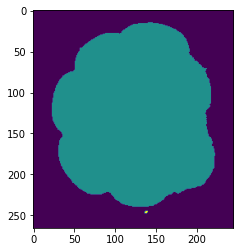

Estimated number of noise points: 6
Estimated number of clusters: 2


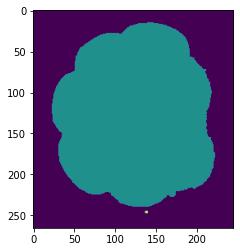

In [10]:
from tqdm import tqdm
from tifffile import imwrite
ci = np.zeros([img.shape[0], img.shape[1], img.shape[2]])

for i in range(0, img.shape[0]):
  cl, ci[i,:] = segment_dbscan(img[i,:], opt)
  plt.imshow(ci[i,:])
  plt.show()  

imwrite(root + 'DBSCANResult' + '.tif', ci.astype('float32'))